Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial #1: Train an image classification model with Azure Machine Learning

In this tutorial, you train a machine learning model both locally and on remote compute resources. You'll use the training and deployment workflow for Azure Machine Learning service (preview) in a Python Jupyter notebook.  You can then use the notebook as a template to train your own machine learning model with your own data. This tutorial is **part one of a two-part tutorial series**.  

This tutorial trains a simple logistic regression using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and [scikit-learn](http://scikit-learn.org) with Azure Machine Learning.  MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of 28x28 pixels, representing a number from 0 to 9. The goal is to create a multi-class classifier to identify the digit a given image represents. 

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train a simple logistic regression model locally using the popular scikit-learn machine learning library 
> * Train multiple models on a remote cluster
> * Review training results, find and register the best model

You'll learn how to select a model and deploy it in [part two of this tutorial](deploy-models.ipynb) later. 

## Prerequisites

Use [these instructions](https://aka.ms/aml-how-to-configure-environment) to:  
* Create a workspace and its configuration file (**config.json**)  
* Save your **config.json** to the same folder as this notebook

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.2


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

Found the config file in: /data/home/team13/notebooks/config.json
openhackworkspace	westus2	Team13	westus2


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'keras'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [9]:
# register model
from azureml.core.model import Model

model = Model.register(model_path = "transfer-model.h5",
                       model_name = "trainedmodel",
                       tags = dict(),
                       description = "pre trained transfer model",
                       workspace = ws)

Registering model trainedmodel


# Create scoring script

In [53]:
%%writefile score.py
import json
import numpy as np
import os

from keras import applications
from keras.models import load_model
from azureml.core.model import Model

def init():
    global model
    global base_model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('trainedmodel')
    # build the VGG16 network
    base_model = applications.VGG16(include_top=False, weights='imagenet')
    # build top model
    model = load_model(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    bottleneck_prediction = base_model.predict(data)
    y_hat = model.predict(bottleneck_prediction)
    return json.dumps(y_hat.tolist())

Overwriting score.py


# Create env file

In [11]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("h5py")
myenv.add_conda_package("keras")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

# create image config

In [12]:
from azureml.core.image import ContainerImage

# Image configuration
image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                 runtime = "python",
                                                 conda_file = "myenv.yml",
                                                 description = "Trained model",
                                                 tags = dict()
                                                 )

In [54]:
# Create the image from the image configuration
image = ContainerImage.create(name = "trainedmodel3", 
                              models = [model], #this is the model object
                              image_config = image_config,
                              workspace = ws
                              )

Creating image


# Deploy image

In [38]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = dict(), 
                                               description = 'Image classification')

In [67]:
from azureml.core.webservice import Webservice

service_name = 'aci-keras-15'
service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                            image = image,
                                            name = service_name,
                                            workspace = ws)
service.wait_for_deployment(show_output = True)
print(service.state)

Creating service
Running.......................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


In [65]:
image.update_creation_state()


In [66]:
print(image.creation_state)

Succeeded


In [51]:
print(service.state)

Healthy


# Test Service

Sending request
[[2.7638578006977683e-24, 6.4509692170127156e-24, 3.140479850901542e-21, 2.230808552049645e-23, 2.8589956790892046e-11, 1.3272124035574875e-23, 7.759541310696374e-23, 7.507654498084548e-10, 1.0298599267214575e-15, 2.7671711412916857e-16, 7.731528807102081e-16, 2.4585737452008946e-16]]
Sending request
[[3.415702237988872e-28, 1.558518164778191e-33, 6.982097708918357e-27, 1.3092619817808904e-28, 8.164590067749426e-25, 3.1895659179194906e-31, 1.2167991064203512e-31, 1.074807729998469e-26, 6.178562234412125e-25, 6.133920540422705e-32, 2.7806046906328205e-27, 0.005368128884583712]]
Sending request
[[1.548818567264909e-30, 1.4574530525562862e-29, 2.6470125600404e-28, 3.805512769848782e-26, 4.1409192083803853e-22, 2.3637721521691527e-25, 1.6726697715143255e-27, 2.2098346053138655e-33, 0.9988024234771729, 1.0331806727849123e-23, 5.867960578932995e-25, 1.388602904733483e-27]]
Sending request
[[0.007575114723294973, 3.5702057307314603e-26, 5.4670522070285045e-27, 3.14355215903542

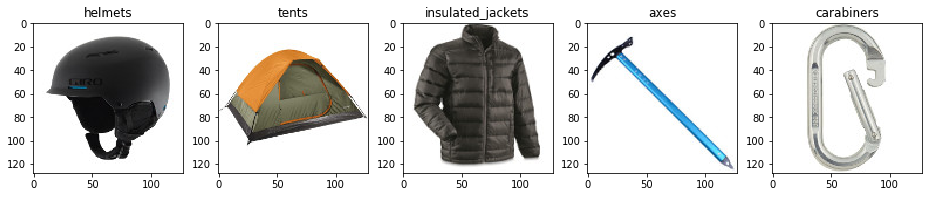

In [69]:
import os
import shutil
import json
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from PIL import Image
#import tensorflow as tf

# Needed to display matplotlib plots in Jupyter
%matplotlib inline

imgdir = 'test_images_from_bing' # Folder containing extracted images

typeList = dict()
typeList[0]='axes'
typeList[1]='boots'
typeList[2]='carabiners'
typeList[3]='crampons'
typeList[4]='gloves'
typeList[5]='hardshell_jackets'
typeList[6]='harnesses'
typeList[7]='helmets'
typeList[8]='insulated_jackets'
typeList[9]='pulleys'
typeList[10]='ropes'
typeList[11]='tents'

# Create a figure to display the images
fig = plt.figure(figsize=(16, 16))

# loop recursively through the folders
dir_num = 0

for subdir, dirs, files in os.walk(imgdir):
    for file in files:
        images = []
        filepath = subdir + os.sep + file
        folder = subdir.rsplit('/', 1)
        # in each folder, get the first file
        imagePIL = PIL.Image.open(filepath)
        
        images.append(np.array(imagePIL).ravel())
        typeName = filepath.rsplit('/', 1)[-1]
        typeName = typeName.split('.')[0]
        
        imageBits = np.array(imagePIL)

        imageBits = imageBits / 255
        imageBits = np.expand_dims(imageBits, axis=0)
        
        test_samples = json.dumps({"data": imageBits.tolist()})
        test_samples = bytes(test_samples, encoding = 'utf8')
        print('Sending request')
        results = json.loads(service.run(input_data=test_samples))
    
        predictedType = np.argmax(results, axis=1)
        textPredictedType = typeList[predictedType[0]]

        # Convert to Numpy Array so we can check the channels
        image = np.array(imagePIL)
        # Add File image to our grid
        a=fig.add_subplot(len(files),len(files),dir_num + 1)
        imgplot = plt.imshow(image)
        # Add the file name (the class of the image)
        # This should be changed to use the prediction pulled back from our model
        # a.set_title(typeName)
        title = 'P:',textPredictedType
        a.set_title(textPredictedType)
        dir_num = dir_num + 1